In [1]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import skimage
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

### Load Dataset

In [2]:
EPOCHS = 30
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
TEST = 'test'
TRAIN = 'train'
VAL = 'val'

### 데이터 전처리, 증강

In [3]:
def data_transforms(phase):
    if phase == TRAIN:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],)
        ])
    if phase == VAL:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],)
        ])
    if phase == TEST:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],)
        ])
        
    return transform

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# dictionary 생성(목적과 transform)
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms(x))
                 for x in [TRAIN, VAL, TEST]}

image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 5216
     Root location: /kaggle/input/chest-xray-pneumonia/chest_xray/train
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 16
     Root location: /kaggle/input/chest-xray-pneumonia/chest_xray/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 624
     Root location: /kaggle/input/chest-xray-pneumonia/chest_xray/test
     Stan

In [6]:
dataloaders = {
    TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size = 4, shuffle = True),
    VAL: torch.utils.data.DataLoader(image_datasets[VAL], batch_size = 1, shuffle = True),
    TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size = 1, shuffle = True),
}

dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x793fb02a53c0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x793ec3bbf1c0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x793ec3bbeaa0>}

In [7]:
len(dataloaders[TRAIN])

1304

In [8]:
dataset_sizes = {
    x: len(image_datasets[x])
    for x in [TRAIN, VAL]
}
print(dataset_sizes)
classes = image_datasets[TRAIN].classes
print(classes)
class_names = image_datasets[TRAIN].classes

print(class_names)

{'train': 5216, 'val': 16}
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


### X-rays 시각화

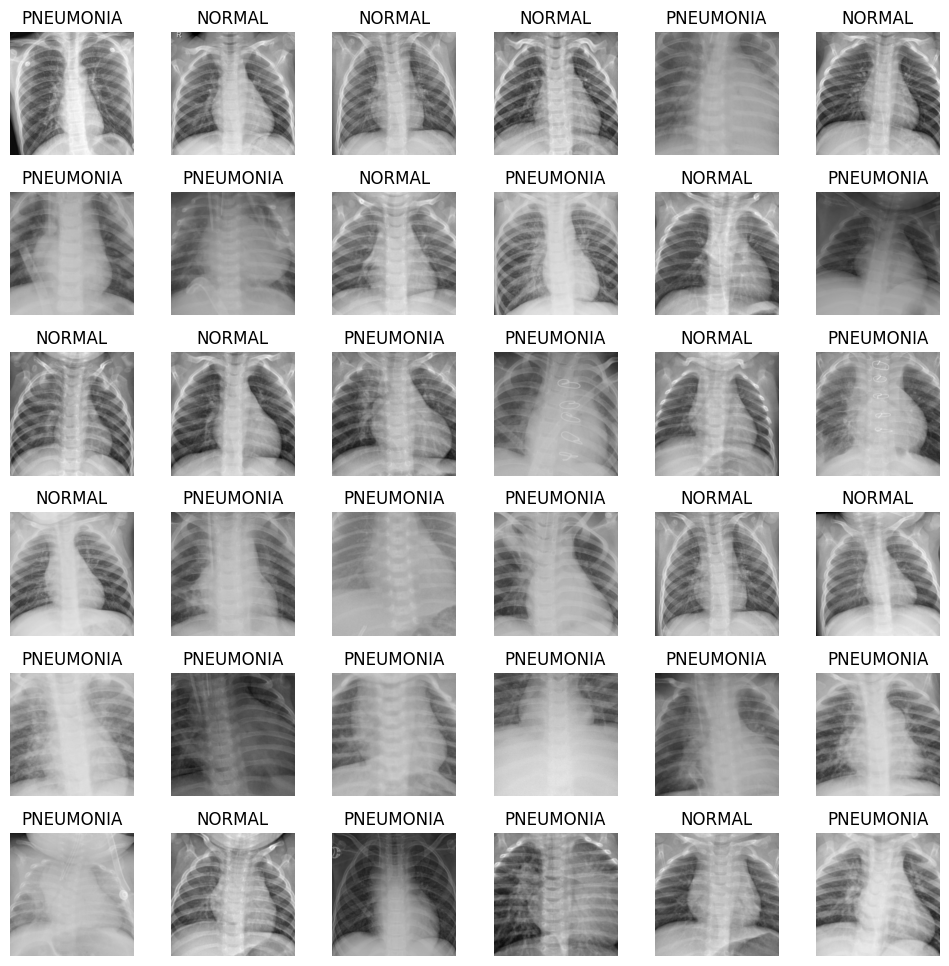

In [9]:
fig, axes = plt.subplots(6, 6, figsize = (12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(6):
    for j in range(6):
        inputs, classes = next(iter(dataloaders[TRAIN]))
        input_img = inputs[0]
        class_label = classes[0]
        inp = input_img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        axes[i, j].imshow(inp)
        axes[i, j].set_title(class_names[class_label.item()])
        axes[i, j].axis('off')
        
plt.show()

In [10]:
inputs, classes = next(iter(dataloaders[TRAIN]))

### Training Function 정의

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        print('='*40)
        
        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for data in dataloaders[phase]:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase ==TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'va' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
    print('Best val Acc: {:4f}'.format(best_acc))
        
    model.load_state_dict(best_model_wts)
    return model
                    

### Pretrained 모델 불러오기

In [12]:
model_pre = models.vgg16(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 173MB/s]


In [13]:
for param in model_pre.features.parameters():
    param.required_grad = False
    
num_features = model_pre.classifier[6].in_features
features = list(model_pre.classifier.children())[:-1] # VGG16 모델의 기존 분류기 제외 모든 레이어 
features.extend([nn.Linear(num_features, len(class_names))])
model_pre.classifier = nn.Sequential(*features)
print(model_pre)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Hyperparameter 정의

In [14]:
model_pre = model_pre.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pre.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 0.01)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer , step_size = 10, gamma = 0.1)

### Train

In [15]:
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs = EPOCHS)

Epoch: 1/30


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.1555 Acc: 0.9392
val Loss: 0.1572 Acc: 0.9375
Epoch: 2/30
train Loss: 0.0675 Acc: 0.9720
val Loss: 0.5762 Acc: 0.7500
Epoch: 3/30
train Loss: 0.0624 Acc: 0.9781
val Loss: 0.1726 Acc: 0.8750
Epoch: 4/30
train Loss: 0.0510 Acc: 0.9816
val Loss: 0.2440 Acc: 0.9375
Epoch: 5/30
train Loss: 0.0591 Acc: 0.9770
val Loss: 0.6696 Acc: 0.6875
Epoch: 6/30
train Loss: 0.0519 Acc: 0.9820
val Loss: 0.3140 Acc: 0.9375
Epoch: 7/30
train Loss: 0.0626 Acc: 0.9768
val Loss: 0.2689 Acc: 0.9375
Epoch: 8/30
train Loss: 0.0659 Acc: 0.9755
val Loss: 0.6216 Acc: 0.6875
Epoch: 9/30
train Loss: 0.0656 Acc: 0.9776
val Loss: 0.8975 Acc: 0.6250
Epoch: 10/30
train Loss: 0.0388 Acc: 0.9866
val Loss: 0.5148 Acc: 0.8125
Epoch: 11/30
train Loss: 0.0328 Acc: 0.9898
val Loss: 0.6167 Acc: 0.7500
Epoch: 12/30
train Loss: 0.0307 Acc: 0.9902
val Loss: 0.3453 Acc: 0.9375
Epoch: 13/30
train Loss: 0.0301 Acc: 0.9914
val Loss: 0.4263 Acc: 0.8125
Epoch: 14/30
train Loss: 0.0293 Acc: 0.9900
val Loss: 0.4757 Acc: 0.8125

### Evaluate

In [16]:
def test_model():
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    input_images = []

    with torch.no_grad():
        # Iterate over test data
        for data in dataloaders[TEST]:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            true_labels.append(labels.item())
            
            input_images.append(inputs)
            
            outputs = model_pre(inputs)
            _, preds = torch.max(outputs.data, 1)

            pred_labels.append(preds.item())

            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()

        acc = running_correct / running_total

    return true_labels, pred_labels, input_images,  running_correct, running_total, acc

### Testing Phase

In [17]:
true_labels, pred_labels, input_images, running_correct, running_total, acc = test_model()

### Results

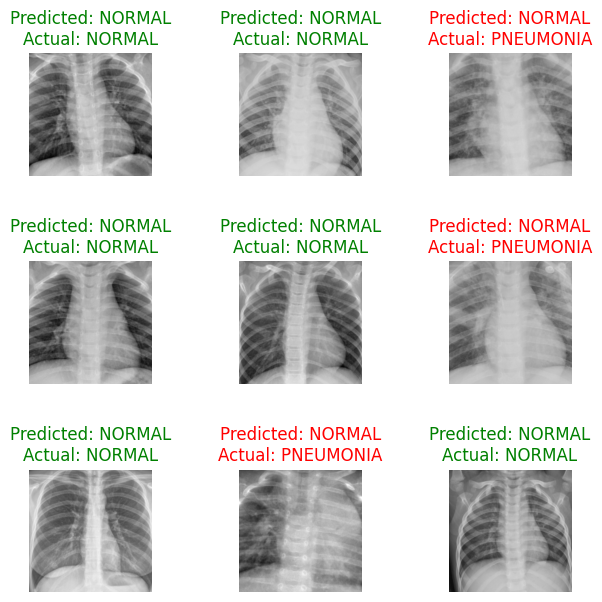

In [18]:
fig, axes = plt.subplots(3,3, figsize=(7, 7))
fig.subplots_adjust(hspace=0.7, wspace=0.7)
x=0

for i in range(3):
    for j in range(3):
        inp = input_images[x].squeeze()
      
        true_label = true_labels[x]
        pred_label = pred_labels[x]

        inp = inp.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

        axes[i, j].imshow(inp)

        title = "Predicted: {}\nActual: {}".format(class_names[pred_label], class_names[true_label])
        color = 'green' if pred_label == true_label else 'red'
        axes[i, j].set_title(title, color=color)

        axes[i, j].axis('off')

        x += 1

plt.show()

In [19]:
print("Total Correct: {} \nTotal Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)

Total Correct: 261.0 
Total Test Images: 624.0
Test Accuracy:  0.4182692307692308
